## ADT Processing

Processing the ADTs.

In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=12

1.4.5.post1


In [3]:
prefix = '/data/codec/production.run/adts/'

### Load in the Data

In [4]:
wells = dict()
for well in range(12):
    wells[well] = dict()
    wells[well]['adata'] = sc.read_10x_h5(prefix + "10x.h5s/well%d/outs/raw_feature_bc_matrix.h5" % (well + 1))
    wells[well]['adata'].var_names_make_unique()

reading /data/codec/production.run/adts/10x.h5s/well1/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well2/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well3/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well4/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well5/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well6/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well7/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well8/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well9/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/well10/outs/raw_feature_bc_matrix.h5
 (0:00:06)
reading /data/codec/production.run/adts/10x.h5s/w

Also load in the barcodes from the mRNA, so I don't have these giant matrices in memory.

In [6]:
path = prefix + '../mrna/concat.bcs.txt'

with open(path,'r') as file:
    bcs = ['-'.join(i.strip().split('-')[:2]) for i in file.readlines()]

### Adjust Cell Barcodes, Filter

I'm adjusting the cell barcodes to make them match their well number, which I also did with the mRNA.

In [5]:
for well in tqdm(wells):
    wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]

Subsetting based on the mRNA barcodes.

In [7]:
for well in tqdm(wells):
    wells[well]['adata'] = wells[well]['adata'][[i for i in bcs if int(i.split('-')[-1]) == well]]

Going to use the `filter_cells` and `filter_genes` functions just to get the `n_counts` column in the `.obs` and `.var`. Not actually filtering, since I'm setting my thresholds to 0.

In [8]:
for well in wells:
    sc.pp.filter_cells(wells[well]['adata'], min_counts=0)
    sc.pp.filter_genes(wells[well]['adata'], min_counts=0)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### Concatenate

In [57]:
concat_adts = dict()

In [58]:
concat_adts['adata'] = wells[0]['adata'].concatenate(*[wells[i]['adata'] for i in range(1,12)])# I really shouldn't do this, I should go back and run cellranger aggr, but for now just concatenate

In [59]:
concat_adts['adata'].var['n_counts'] = concat_adts['adata'].var[[i for i in concat_adts['adata'].var.columns if i.startswith('n_counts')]].sum(axis=1)

In [60]:
concat_adts['raw'] = concat_adts['adata'].copy()

### Filter Proteins, Transform Data

Trying to see if any proteins have much lower counts. We usually see even antibodies that weren't even added into the mix still showing some counts.

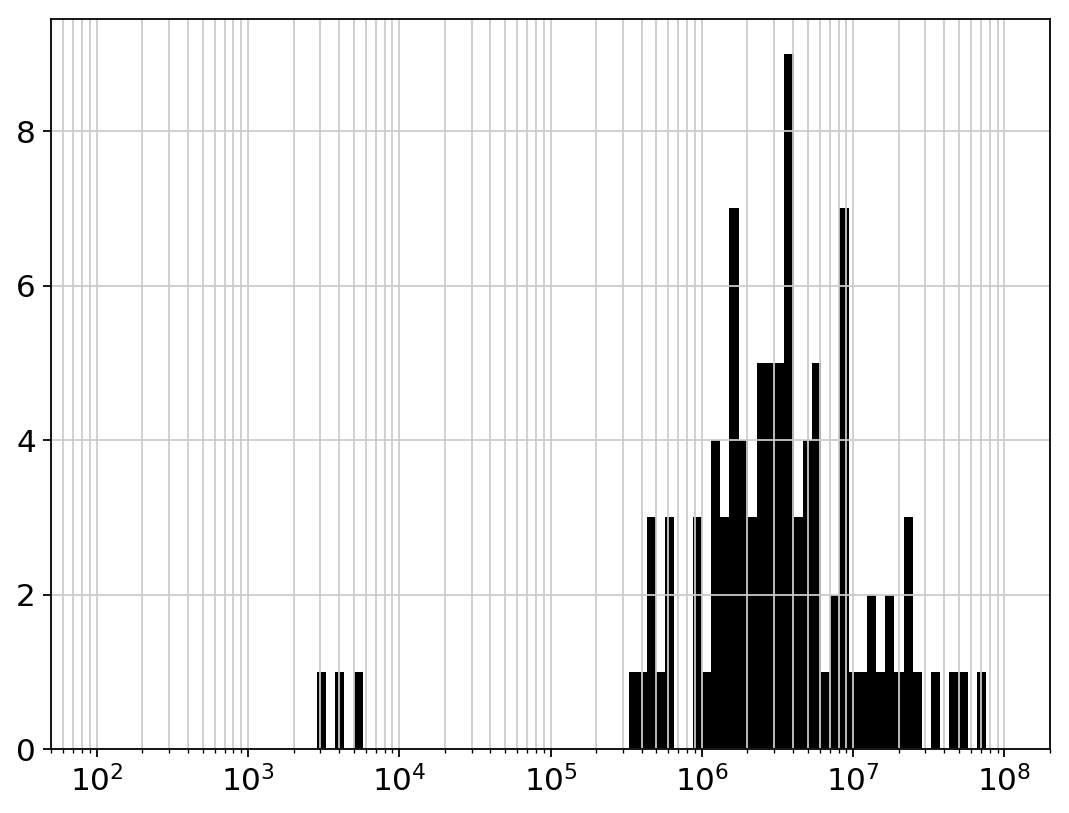

In [61]:
plt.figure(figsize=(8,6))
plt.hist(concat_adts['adata'].var['n_counts'].values, color='k', bins=np.logspace(np.log10(1e2),np.log10(1e8), 100))
plt.grid(False)
plt.grid(True, 'both', 'both')
plt.xscale('log')
# plt.yscale('log')

Going to only keep those proteins with counts > 100K, since they're probably not real.

In [62]:
concat_adts['adata'] = concat_adts['adata'][:,concat_adts['adata'].var['n_counts'] > 1e5].copy()

Now normalize per cell and log the data.

In [63]:
sc.pp.normalize_per_cell(concat_adts['adata'], counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Fix Distributions

I noticed that some cells in the distributions stretch out the range more than needed. They seem to have zero counts, but are clearly not even the "negative" distribution. For whatever reason, they did not record any alignments to the protein. In order for these not to skew the distribution after scaling, I'm going to clip the counts to a lower threshold.

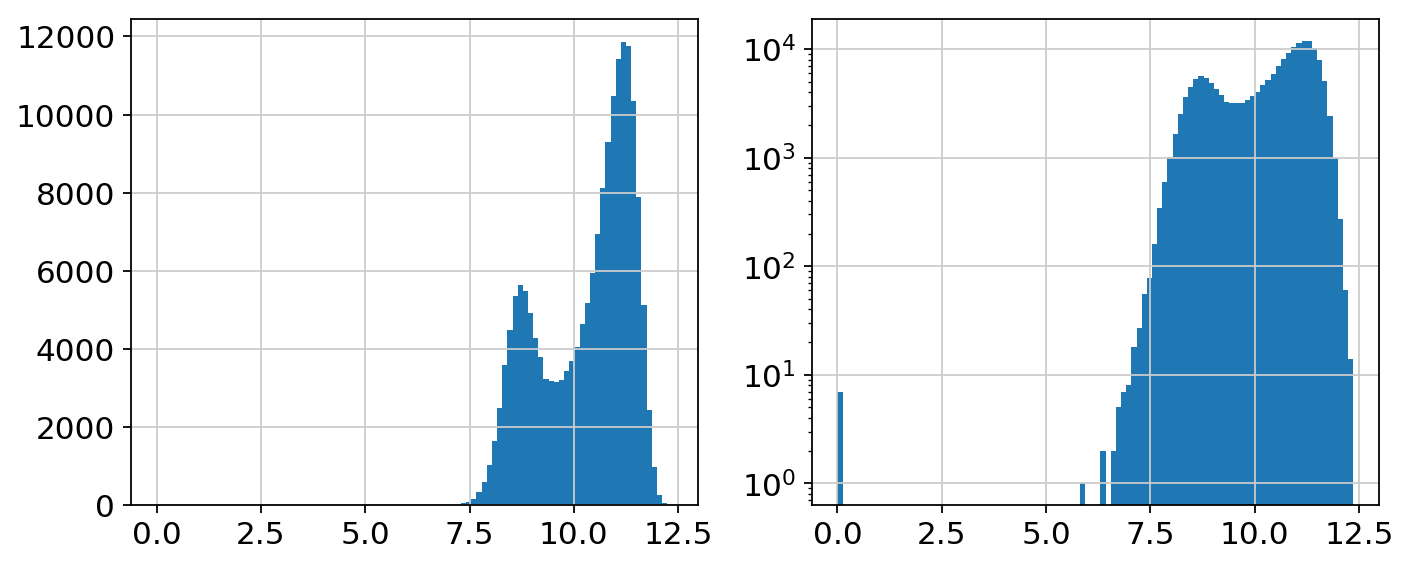

In [65]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(concat_adts['adata'].obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].hist(concat_adts['adata'].obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].set_yscale('log');

See, there are a very small number of cells with counts of close to or at zero while the rest of the cells show counts in the 1000s or 10s of 1000s. This becomes a problem when I scale the data.

In [66]:
proteins = concat_adts['adata'].var_names

To find the lower value to clip at, I'm just going to use the bins from the histogram itself, and find the first non-zero bin after the initial peak, if there _is_ an initial peak.

In [67]:
shifts = list()
for protein in tqdm(proteins):
    n, bins, patches = plt.hist(concat_adts['adata'].obs_vector(protein),bins=100)
    plt.close()
    shifts.append(bins[n.argmin() + (n[n.argmin():] > 0).argmax()])

In [68]:
new_X = concat_adts['adata'].X.toarray()
for i in tqdm(range(len(proteins))):
    new_X[:,i] = np.clip(new_X[:,i],shifts[i], np.inf)

In [69]:
concat_adts['adata'].X = new_X

In [70]:
concat_adts['unscaled'] = concat_adts['adata'].copy()

In [71]:
sc.pp.scale(concat_adts['adata'], max_value=10)

    ... clipping at max_value 10


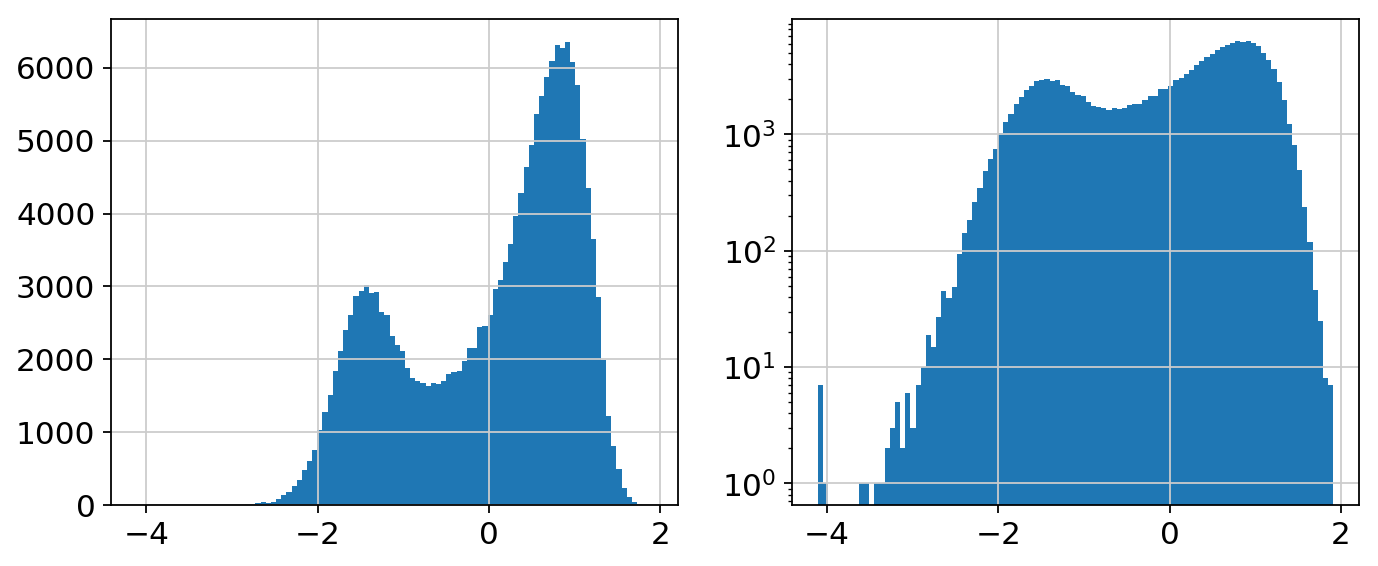

In [72]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(concat_adts['adata'].obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].hist(concat_adts['adata'].obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].set_yscale('log');

Looks a bit better. I'll keep it like that.

In [27]:
path = prefix + 'pkls/concat.adts.norm.log.pkl'

# with open(path,'wb') as file:
#     pkl.dump(concat_adts, file)
    
with open(path,'rb') as file:
    concat_adts = pkl.load(file)